# Fit a RL model on individual data

In [1]:
from rlssm.utility.load_data import load_example_dataset
from rlssm.model.models_RL import RLModel_2A

import pandas as pd

## Import individual data

In [2]:
# import some example data:
data = load_example_dataset(hierarchical_levels = 1)

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,6,1,1,51,44,4,2,1,2.133333,0
1,6,1,2,34,40,2,1,1,1.074587,0
2,6,1,3,40,30,2,1,2,1.184882,0
3,6,1,4,47,43,3,1,2,1.564148,0
4,6,1,5,45,35,2,1,4,1.283289,1


## Initialize the model

In [3]:
# you can "turn on and off" different mechanisms:
model = RLModel_2A(hierarchical_levels = 1,
                   increasing_sensitivity = False,
                   separate_learning_rates = True)

Using cached StanModel


In [4]:
model.priors

{'sensitivity_priors': {'mu': 1, 'sd': 50},
 'alpha_pos_priors': {'mu': 0, 'sd': 1},
 'alpha_neg_priors': {'mu': 0, 'sd': 1}}

## Fit

In [5]:
# sampling parameters
n_warmup = 500
n_sampling = 2000
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options in a learning block (participants see 2 at a time)
initial_value_learning = 27.5 # initial learning value (Q0)

In [6]:
model_fit = model.fit(
    data, 
    K, 
    initial_value_learning,
    sensitivity_priors={'mu': 0, 'sd': 5},
    thin = n_thin,
    iter_warmup=n_warmup,
    iter_sampling=n_sampling,
    chains = n_chains)

21:30:04 - cmdstanpy - INFO - CmdStan start processing


Fitting the model using the priors:
sensitivity_priors {'mu': 0, 'sd': 5}
alpha_pos_priors {'mu': 0, 'sd': 1}
alpha_neg_priors {'mu': 0, 'sd': 1}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

21:30:05 - cmdstanpy - INFO - CmdStan done processing.
21:30:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr.stan', line 72, column 1 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)


## get Rhat

In [7]:
model_fit.rhat

,rhat,variable
name,,
lp__,1.00264,lp__
alpha_pos,1.00376,alpha_pos
alpha_neg,1.00592,alpha_neg
sensitivity,1.00365,sensitivity
log_p_t[1],NaN,log_p_t[1]
...,...,...
log_lik[236],1.00087,log_lik[236]
log_lik[237],1.00118,log_lik[237]
log_lik[238],1.00158,log_lik[238]


## get wAIC

In [8]:
model_fit.waic

{'lppd': -85.21003813561173,
 'p_waic': 4.647449363553035,
 'waic': 179.71497499832952,
 'waic_se': 16.861815329889374}

## Posteriors

In [9]:
model_fit.samples.describe()

,transf_alpha_pos,transf_alpha_neg,transf_sensitivity
count,4000.000000,4000.000000,4000.000000
mean,0.206948,0.358710,0.337370
std,0.195473,0.229860,0.084857
min,0.013737,0.021611,0.173028
25%,0.054841,0.175399,0.273937
50%,0.112262,0.310230,0.321870
75%,0.334071,0.492984,0.386851
max,0.987177,0.999965,0.719147


In [10]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

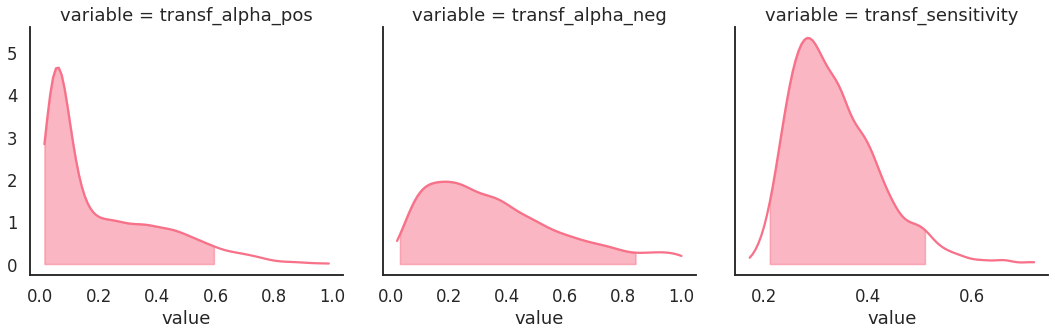

In [11]:
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

## Posterior predictives

### Ungrouped

In [12]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=1000)
pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 231 232 233 234   
sample                                                 ...                   
1               0   1   1   0   0   1   0   1   0   1  ...   1   1   1   1   
2               0   0   1   0   0   0   1   0   0   0  ...   1   1   0   1   
3               0   1   1   0   1   1   1   1   0   1  ...   1   1   1   1   
4               0   1   1   0   1   0   1   0   0   0  ...   1   1   1   1   
5               0   1   1   1   1   1   0   1   1   1  ...   1   1   1   1   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
996             1   0   0   0   1   0   0   1   0   1  ...   1   1   1   0   
997             0   0   1   0   1   0   0   1   1   1  ...   1   1   1   0   
998             0   1   1   1   1   0   0   1   0   0  ...   1   1   1   1   
999             0   0   0   0   1   0   1   1   0   1  ...   1   1   1   1   
1000            0   1   0   0   1   0   1   0   0   1  ...   1   0   1   0   

variable                          
trial    235 236 237 238 239 240  
sample                            
1          1   1   1   1   1   1  
2          1   1   1   1   0   1  
3          1   1   1   1   1   1  
4          1   1   0   1   1   1  
5          1   1   1   1   0   1  
...       ..  ..  ..  ..  ..  ..  
996        1   1   0   1   1   1  
997        1   1   1   1   0   1  
998        1   1   1   1   1   1  
999        1   1   1   1   1   1  
1000       1   1   1   1   0   1  

[1000 rows x 240 columns]

In [13]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=1000)
pp_summary

,mean_accuracy
sample,
1,0.820833
2,0.783333
3,0.787500
4,0.791667
5,0.850000
...,...
996,0.816667
997,0.795833
998,0.833333


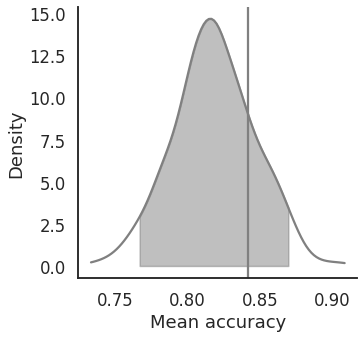

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

### Grouped

In [15]:
import numpy as np

In [16]:
# Define new grouping variables, in this case, for the different choice pairs, but any grouping var can do
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [17]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], 
                                                    n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1           1          AB          1            0.500000
                                   2            0.750000
                                   3            0.250000
                                   4            0.500000
                                   5            0.750000
...                                                  ...
3           8          CD          496          0.666667
                                   497          0.666667
                                   498          1.000000
                                   499          0.666667
                                   500          1.000000

[47000 rows x 1 columns]

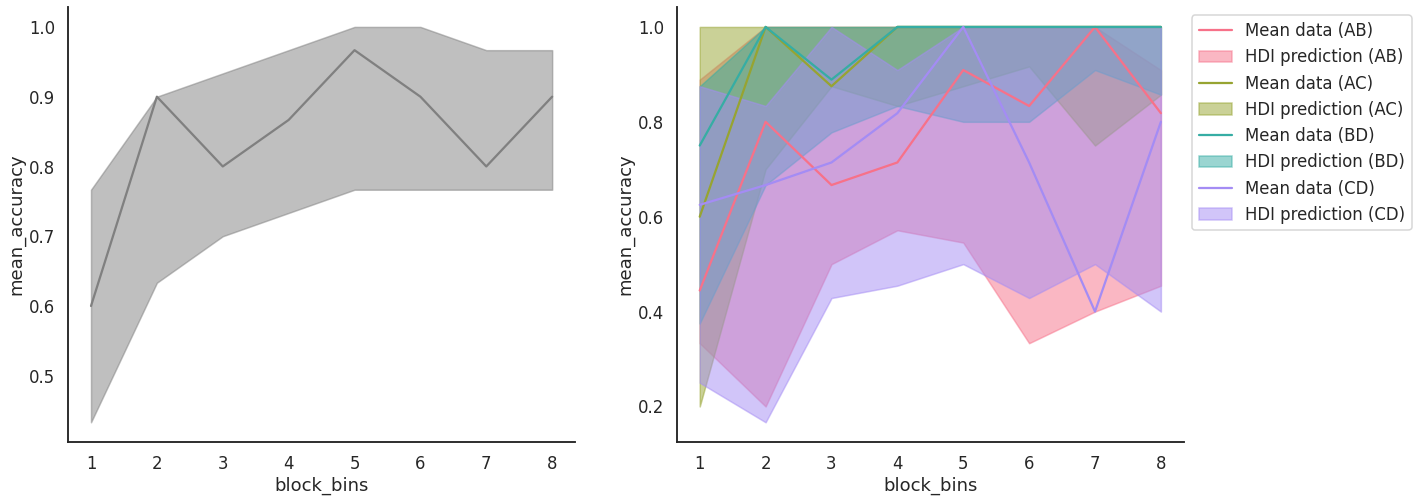

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()